In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Tue Feb 11 11:13:42 PST 2020


In [2]:
import seaborn as sns
import scipy.stats

# Gaussian copula to correlation two risk factor exposures

And then some investigation of how much error this introduces in the PAF.

In [4]:
# Simulate for testing purposes

N = 10_000  # number of individuals

# set random seed for reproducibility
np.random.seed(12345)

# simulate data (to be replaced with real data, e.g. from NHANES, eventually)
df = pd.DataFrame(index=range(N))
df['SBP'] = np.random.normal(130, 20, size=N)
df['LDL-C'] = np.random.normal(4+(df.SBP-130)/20, 1, size=N)  # intentionally include correlation between SBP and LDL-C
df

,SBP,LDL-C
0,125.905847,5.723323
1,139.578867,3.322323
2,119.611226,3.089911
3,118.885394,3.845074
...,...,...
9996,173.045882,8.809667
9997,129.865889,5.465636
9998,105.705538,3.818431
9999,143.099773,7.605454


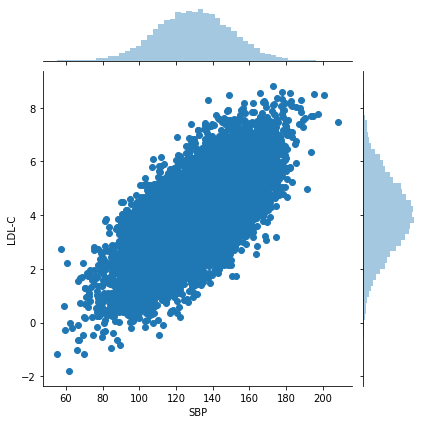

In [6]:
sns.jointplot(df['SBP'], df['LDL-C'])

# What we want from the microdata is simply the Spearman R value, which captures the correlation of birthweight and WHZ as continuous variables

In [7]:
rho, p_val = scipy.stats.spearmanr(df['SBP'], df['LDL-C'])
rho

0.6942625526106255

# What will we use that for?

We will generate a multivariate normal with that rho, and then use that to generate a distribution that is marginally uniform, but with that rho, and then use that to generate a distribution that in its margins matches the SPB and LDL-C from GBD, but also has Spearman correlation rho:

0.6797538355495384

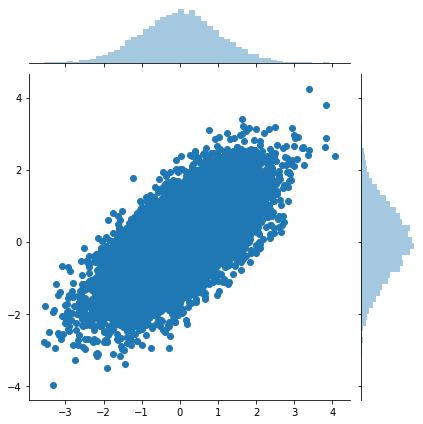

In [8]:
probit_propensity = np.random.multivariate_normal([0,0], [[1, rho],
                                                         [rho, 1]], size=N)
sns.jointplot(probit_propensity[:,0], probit_propensity[:,1])
rho, p_val = scipy.stats.spearmanr(probit_propensity[:,0], probit_propensity[:,1])
rho

0.6797538355495384

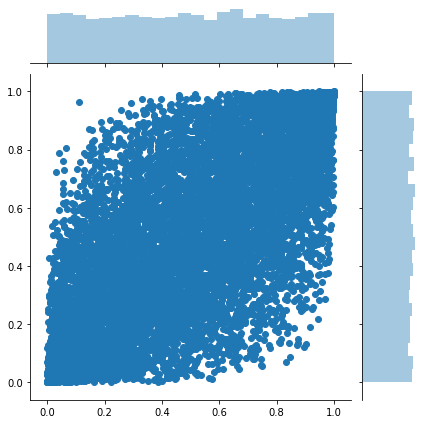

In [9]:
propensity = scipy.stats.norm().cdf(probit_propensity)
sns.jointplot(propensity[:,0], propensity[:,1])
rho, p_val = scipy.stats.spearmanr(propensity[:,0], propensity[:,1])
rho

In [10]:
# HACK: instead of loading marginals from GBD, I'm going to re-use the ones
# I synthesized above

exposure1_vals = df['SBP'].sort_values().values
exposure2_vals = df['LDL-C'].sort_values().values

def exposure1_from_propensity(p):
    p = np.array(p)
    i = np.array(np.floor(p*len(exposure1_vals)), dtype=int)
    return exposure1_vals[i]

def exposure2_from_propensity(p):
    p = np.array(p)
    i = np.array(np.floor(p*len(exposure2_vals)), dtype=int)
    return exposure2_vals[i]


In [11]:
# now map from propensity to value
df_synthetic = pd.DataFrame(index=range(N))
df_synthetic['SBP'] = exposure1_from_propensity(propensity[:,0])
df_synthetic['LDL-C'] = exposure2_from_propensity(propensity[:,1])
df_synthetic

,SBP,LDL-C
0,134.011378,5.192848
1,116.002529,3.155872
2,120.862054,1.630903
3,110.848538,2.214022
...,...,...
9996,91.988864,3.282778
9997,90.701909,1.307473
9998,122.352818,4.338779
9999,136.862764,3.626774


0.6797565466113832

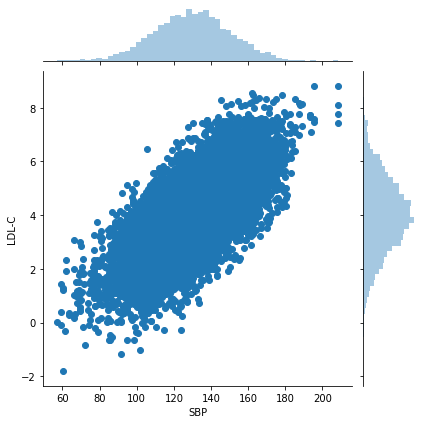

In [12]:
sns.jointplot(df_synthetic['SBP'], df_synthetic['LDL-C'])
rho, p_val = scipy.stats.spearmanr(df_synthetic['SBP'], df_synthetic['LDL-C'])
rho

# The anticipated problem with this approach: how does correlation affect the joint PAF?

This is not relevant to the material above---using the Gaussian Copula to capture the correlation between risk-factor exposure will be fine.  The problem is when we then layer at RiskEffect component into our model, to make the risk have a effect on the incidence or mortality rate of our cause model.  Without loss of generality, suppose the risk effect will change the incidence of first MI.

We have traditionally handled this by calculating a risk-deleted incidence:
$$
i_0 = \left(1-\text{PAF}\right) \cdot i_{\text{GBD}}
$$

If we _just_ include one risk effect, I think we're still ok, even with correlation.  But if we have two risk effects, we have previously used assumption
$$
1 - \text{PAF}_{\text{joint}} = \left(1 - \text{PAF}_{\text{SBP}}\right)\cdot\left(1 - \text{PAF}_{\text{LDL-C}}\right).
$$

The more correlated the risk exposure, the more wrong this assumption.

I propose we continue to assume that the relative risks have a "log linear" relationship with incidence:
$$
i_{e_1, e_2} = i_0 \cdot \left(\text{RR}_1\right)^{e_1}\cdot \left(\text{RR}_2\right)^{e_2},
$$
where I have written $e_1$ and $e_2$ as "standardized" exposures, after scaling and shifting so that the TMREL is 0.0 and a one unit increment gives the relative increase in disease burden reported by GBD.


With the log-linear assumption, we can calculate the PAF from first principles as a double integral (below $p_{e_1,e_2}$ denotes the joint probability density of exposure level $(e_1,e_2)$ in the population:

\begin{align*}
i_{\text{GBD}} &= \int_{e_1} \int_{e_2} i_{e_1, e_2} p_{e_1,e_2} de_1 de_2\\
&= \int_{e_1} \int_{e_2} i_0 \cdot \left(\text{RR}_1\right)^{e_1}\cdot \left(\text{RR}_2\right)^{e_2}
p_{e_1,e_2} de_1 de_2\\
&= \int_{e_1} \int_{e_2} \left(1-\text{PAF}\right) \cdot i_{\text{GBD}} \cdot \left(\text{RR}_1\right)^{e_1}\cdot \left(\text{RR}_2\right)^{e_2}
p_{e_1,e_2} de_1 de_2\\
\end{align*}

Dividing through and cancelling terms yields a solution:
$$
\frac{1}{1-\text{PAF}} = \int_{e_1} \int_{e_2} \left(\text{RR}_1\right)^{e_1}\cdot \left(\text{RR}_2\right)^{e_2}
p_{e_1,e_2} de_1 de_2,
$$

In [17]:
# there are lots of ways to approximate this integral, but here is a cool one:
rr_1 = 1.1
rr_2 = 1.3

e1 = np.clip((df['SBP'] - 120)/10, 0, np.inf)  # rescale exposures 
e2 = np.clip((df['LDL-C'] - 4), 0, np.inf)

one_over_one_minus_paf = np.mean(rr_1**e1 * rr_2**e2)
paf = 1 - 1/(one_over_one_minus_paf)
paf

0.2876599133890043

In [20]:
# how does this compare to multiplicative approx of paf?
ooomp_1 = np.mean(rr_1**e1)
paf_1 = 1 - 1/ooomp_1

ooomp_2 = np.mean(rr_2**e2)
paf_2 = 1 - 1/ooomp_2

1 - (1 - paf_1) * (1 - paf_2)

0.26991555474806306